# 01 - ComCam x Milliquas
**Author:** Olivia Lynn  
**Last Run:** March 27, 2025

*Part of the [AGN Variability project from March 2025](https://docs.google.com/document/d/1yb43z7vrG5-FIL6lNZjVkIx41jKSCl698d51RQhXRqg/edit?tab=t.0)*

## Set up
Imports and dask

In [ ]:
import lsdb

import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from dask.distributed import Client
from nested_pandas import NestedDtype

In [2]:
client = Client(n_workers=4, memory_limit="auto")
client

/sdf/group/rubin/sw/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43139 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:43139/status,
Dashboard: http://127.0.0.1:43139/status,Workers: 4
Total threads: 28,Total memory: 405.17 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37841,Workers: 4
Dashboard: http://127.0.0.1:43139/status,Total threads: 28
Started: Just now,Total memory: 405.17 GiB
Comm: tcp://127.0.0.1:42791,Total threads: 7
Dashboard: http://127.0.0.1:44081/status,Memory: 101.29 GiB
Nanny: tcp://127.0.0.1:36187,


## Get catalogs
ComCam and MilliQuas

In [3]:
comcam_cat = lsdb.read_hats(
    "/sdf/data/rubin/shared/lsdb_commissioning/hats/w_2025_11/dia_object_lc",
    margin_cache="/sdf/data/rubin/shared/lsdb_commissioning/hats/w_2025_11/dia_object_lc_5arcs",
)

In [4]:
# This cell from: https://github.com/lsst-sitcom/linccf/blob/main/demo_notebooks/periodic_lightcurves.ipynb

def cast_nested(df, columns):
    return df.assign(
        **{
            col: df[col].astype(NestedDtype.from_pandas_arrow_dtype(df.dtypes[col]))
            for col in columns
        },
    )

comcam_cat = comcam_cat.map_partitions(
    cast_nested, columns=["diaSource", "diaObjectForcedSource"]
)

In [5]:
miliquas_cat = lsdb.read_hats(
    "/sdf/data/rubin/user/olynn/AGNs/hats/Milliquas_v8",
    margin_cache="/sdf/data/rubin/u/olynn/AGNs/hats/Milliquas_v8_margin/Milliquas_v8_10arcs",
)

## Do crossmatch
ComCam x MilliQuas

In [6]:
comcam_x_miliquas = comcam_cat.crossmatch(miliquas_cat, suffixes=["_COM", "_MIL"])
comcam_x_miliquas

,diaObjectId_COM,ra_COM,dec_COM,nDiaSources_COM,radecMjdTai_COM,tract_COM,diaSource_COM,diaObjectForcedSource_COM,RA_MIL,DEC_MIL,NAME_MIL,TYPE_MIL,RMAG_MIL,BMAG_MIL,COMMENT_MIL,R_MIL,B_MIL,Z_MIL,CITE_MIL,ZCITE_MIL,XNAME_MIL,RNAME_MIL,LOBE1_MIL,LOBE2_MIL,_dist_arcsec
npartitions=212,,,,,,,,,,,,,,,,,,,,,,,,,
"Order: 0, Pixel: 0",int64[pyarrow],double[pyarrow],double[pyarrow],int64[pyarrow],double[pyarrow],int64[pyarrow],"nested<visit: [int64], detector: [int16], band...","nested<parentObjectId: [int64], coord_ra: [dou...",double[pyarrow],double[pyarrow],string[pyarrow],string[pyarrow],float[pyarrow],float[pyarrow],string[pyarrow],string[pyarrow],string[pyarrow],float[pyarrow],string[pyarrow],string[pyarrow],string[pyarrow],string[pyarrow],string[pyarrow],string[pyarrow],double[pyarrow]
"Order: 0, Pixel: 4",...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Order: 6, Pixel: 35957",...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Order: 3, Pixel: 562",...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


## Verify crossmatch

/sdf/home/o/olynn/hats/src/hats/inspection/visualize_catalog.py:309: UserWarning: This plot contains HEALPix pixels smaller than a pixel of the plot. Some values may be lost
  warnings.warn(


(<Figure size 1000x500 with 2 Axes>,
 <WCSAxes: title={'center': 'COMCAM x Milliquas'}>)

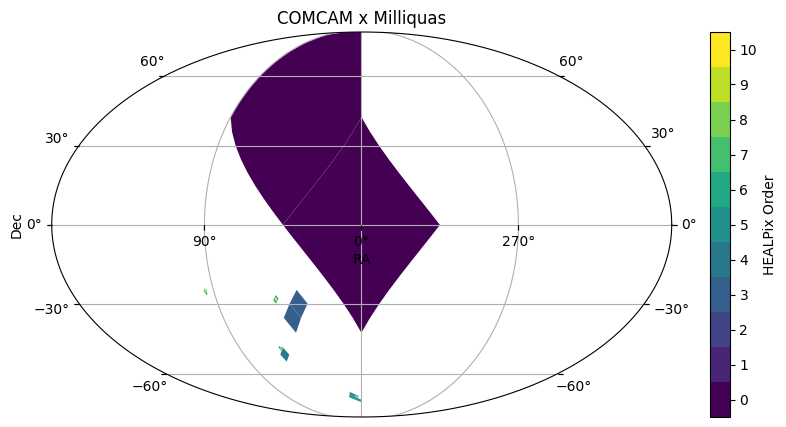

In [7]:
comcam_x_miliquas.plot_pixels(plot_title="COMCAM x Milliquas")

### Are the AGNs found in ComCam roughly the same brightness (in mag) as what is reported in MiliQuas?

In [8]:
ndf = comcam_x_miliquas.partitions[0].compute()

print(len(ndf))
print(ndf.columns)
print(ndf.index)

87
Index(['diaObjectId_COM', 'ra_COM', 'dec_COM', 'nDiaSources_COM',
       'radecMjdTai_COM', 'tract_COM', 'diaSource_COM',
       'diaObjectForcedSource_COM', 'RA_MIL', 'DEC_MIL', 'NAME_MIL',
       'TYPE_MIL', 'RMAG_MIL', 'BMAG_MIL', 'COMMENT_MIL', 'R_MIL', 'B_MIL',
       'Z_MIL', 'CITE_MIL', 'ZCITE_MIL', 'XNAME_MIL', 'RNAME_MIL', 'LOBE1_MIL',
       'LOBE2_MIL', '_dist_arcsec'],
      dtype='object')
Index([9583286176765237, 9583286177775461, 9583286184943462, 9589207111731801,
       9605063046625884, 9605063059806735, 9612527462542422, 9612527476665096,
       9612527488394568, 9615793303641423, 9615793307248127, 9615793327928411,
       9625426037900582, 9625426038428944, 9625426078509712, 9625426086025873,
       9625426131103677, 9625426179556151, 9629002456994271, 9629513964803269,
       9629578303618231, 9629578309631688, 9629578314344802, 9629578319002810,
       9629995725186279, 9629995726864378, 9629995739004293, 9634023935027569,
       9634690500908761, 9634690501919

In [ ]:
# Absolute and relative differences in the magnitudes of the first partition

# Using the mean of the "scienceMag" from the COMCAM sources
# and the "RMAG_MIL" from the Milliquas objects

rows_to_print = 10
for i in ndf.index:
    mean_mag_COM = np.mean(ndf.loc[i, "diaSource_COM"]["scienceMag"])
    mag_MIL = ndf.loc[i, "RMAG_MIL"]
    abs_diff = np.abs(mean_mag_COM - mag_MIL)
    rel_diff = abs_diff / mag_MIL

    if rows_to_print:
        print(f"Abs: {abs_diff:>5.2}, Rel: {rel_diff:.2}")
        rows_to_print -= 1

    if rel_diff > 0.5:
        raise ValueError("Relative difference is too large")

Abs:   1.2, Rel: 0.06
Abs:  0.97, Rel: 0.05
Abs:  0.39, Rel: 0.02
Abs:  0.32, Rel: 0.017
Abs:   1.0, Rel: 0.051
Abs:   1.1, Rel: 0.056
Abs:  0.63, Rel: 0.033
Abs:   0.3, Rel: 0.016
Abs: 0.019, Rel: 0.001
Abs:  0.38, Rel: 0.019


## Plot lightcurves

"Depending on the numer of the objects we can discuss how to do this best."

In [ ]:
# There are 87 rows in the first partition

# This is a similar order of magnitude as "ZTF and PS1 for SNAD catalog" (link), so can reference if needed
# https://docs.lsdb.io/en/stable/tutorials/pre_executed/zubercal-ps1-snad.html

In [23]:
good_indices = []

for i in ndf.index:
    if ndf.loc[i, "nDiaSources_COM"] > 20:
        print(f"Row {i} has {ndf.loc[i, 'nDiaSources_COM']} sources")
        good_indices.append(i)

print(len(good_indices))

Row 9612527476665096 has 22 sources
Row 9634023935027569 has 28 sources
Row 9634690525906647 has 21 sources
Row 9785092585129552 has 34 sources
4


### Mag LCs

Referencing plots in: https://github.com/lsst-sitcom/linccf/blob/main/demo_notebooks/periodic_lightcurves.ipynb

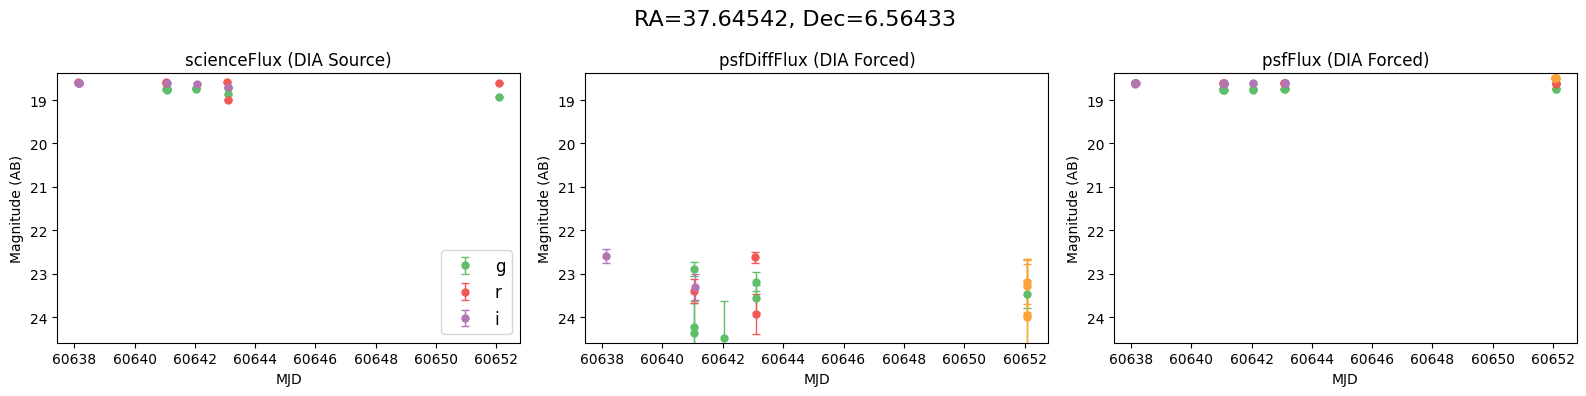

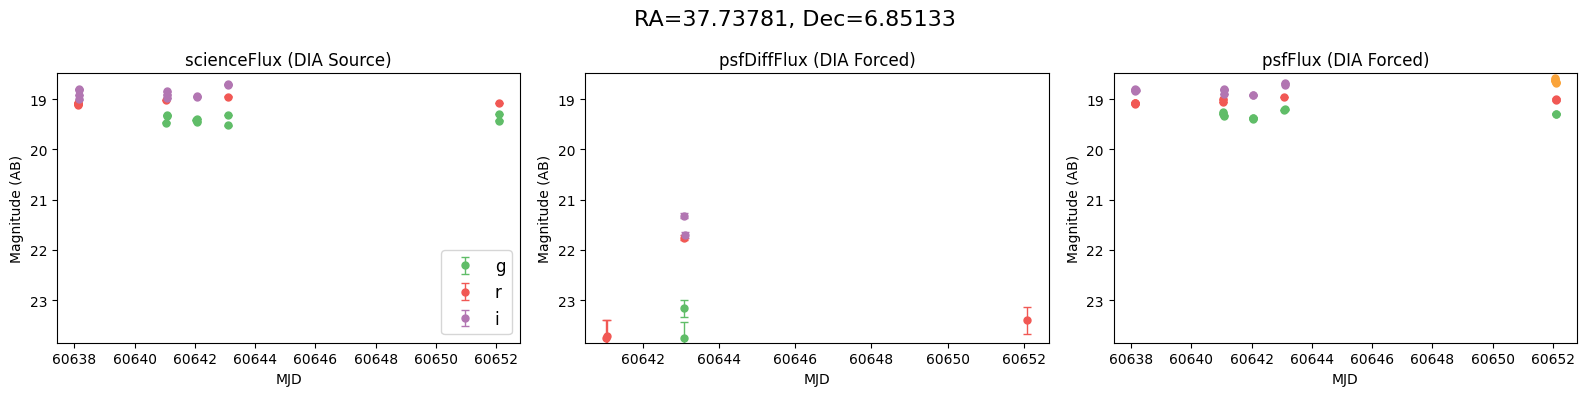

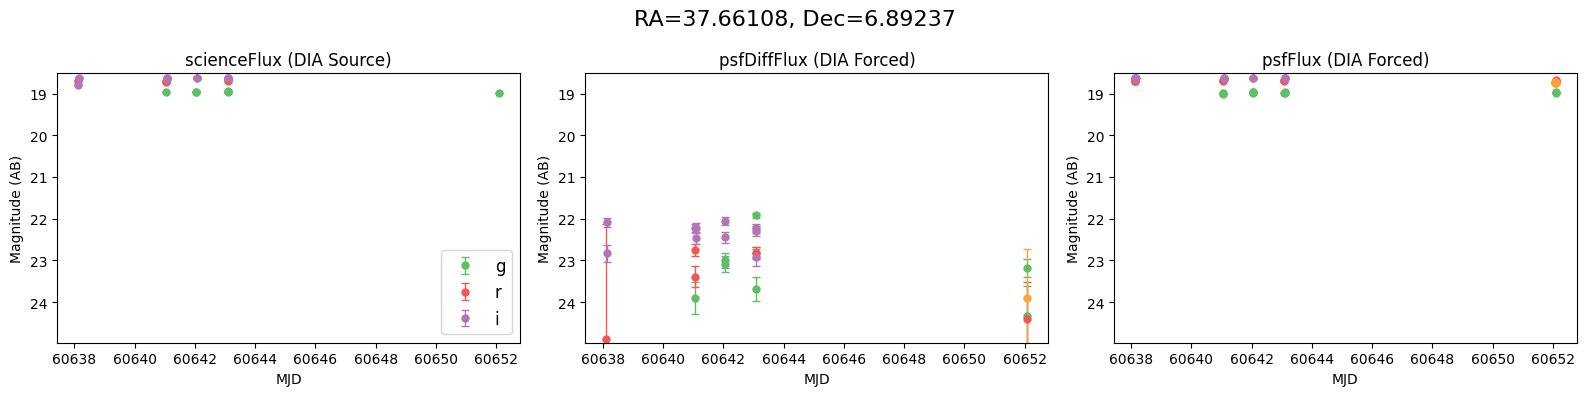

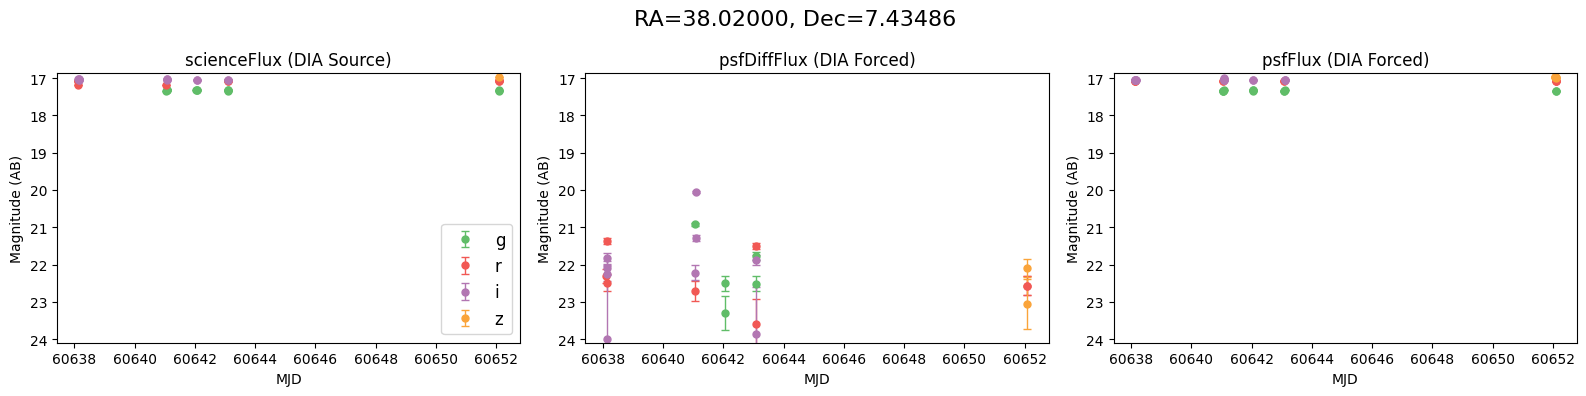

In [ ]:
COLORS = {
    "u": "#5DA5DA",  # sky blue
    "g": "#60BD68",  # leafy green
    "r": "#F15854",  # warm red
    "i": "#B276B2",  # lavender/magenta
    "z": "#FAA43A",  # orange/yellow
    "y": "#4D4D4D",  # dark gray (neutral anchor)
}

def create_mag_errors(flux, flux_err):
    # Make sure everything is valid and flux ± err stays positive
    upper = flux + flux_err
    lower = flux - flux_err
    mask = (
        flux.notna()
        & flux_err.notna()
        & (flux > 0)
        & (upper > 0)
        & (lower > 0)
    )

    # Initialize with NaNs
    mag = np.full_like(flux, np.nan, dtype=float)
    mag_err = np.full_like(flux, np.nan, dtype=float)

    # Apply the AB mag conversion only to valid values
    valid_flux = flux[mask]
    valid_err = flux_err[mask]

    mag[mask] = u.nJy.to(u.ABmag, valid_flux)
    upper_mag = u.nJy.to(u.ABmag, valid_flux + valid_err)
    lower_mag = u.nJy.to(u.ABmag, valid_flux - valid_err)
    mag_err[mask] = -(upper_mag - lower_mag) / 2

    return pd.Series(mag, index=flux.index), pd.Series(mag_err, index=flux.index)

def plot_mag_scale(ax, lc, flux_col, flux_err_col, x_name, x_label, show_legend=False):
    mag_vals = []
    for band, color in COLORS.items():
        band_lc = lc.query(f"band == '{band}'")
        if band_lc.empty:
            continue
        mag, mag_err = create_mag_errors(band_lc[flux_col], band_lc[flux_err_col])
        ax.errorbar(
            band_lc[x_name],
            mag,
            mag_err,
            fmt="o",
            label=band,
            color=color,
            alpha=1,
            markersize=5,
            capsize=3,
            elinewidth=1,
        )
        mag_vals.extend(mag.dropna().values)
    ax.set_xlabel(x_label)
    ax.set_ylabel("Magnitude (AB)")
    ax.invert_yaxis()
    if show_legend:
        ax.legend(loc="lower right", fontsize=12)
    return mag_vals

def scale_mag_y_axis(ax, all_mags):
    if all_mags[0]:
        ymin, ymax = np.nanmin(all_mags[0]), np.nanmax(all_mags[0])
        for i in range(3):
            ax[0, i].set_ylim(ymax + 0.1, ymin - 0.1)

def plot_mag_lightcurves(ax, row):
    datasets = [
        ("scienceFlux", "DIA Source", row.diaSource_COM),
        ("psfDiffFlux", "DIA Forced", row.diaObjectForcedSource_COM),
        ("psfFlux", "DIA Forced", row.diaObjectForcedSource_COM),
    ]
    all_mags = [[], []]
    for i, (flux_col, label, lc) in enumerate(datasets):
        flux_err_col = f"{flux_col}Err"
        ax[0, i].set_title(f"{flux_col} ({label})")

        all_mags[0].extend(
            plot_mag_scale(ax[0, i], lc, flux_col, flux_err_col, "midpointMjdTai", "MJD", show_legend=(i == 0))
        )
    return all_mags

# Now plot
for i in good_indices:
    row = ndf.loc[i]
    fig, ax = plt.subplots(1, 3, figsize=(16, 4))  # Just one row now
    fig.suptitle(f"RA={row.ra_COM:.5f}, Dec={row.dec_COM:.5f}", fontsize=16)
    all_mags = plot_mag_lightcurves(np.expand_dims(ax, 0), row)  # Make ax 2D for consistency
    scale_mag_y_axis(np.expand_dims(ax, 0), all_mags)
    plt.tight_layout()
    plt.show()

### Flux LCs

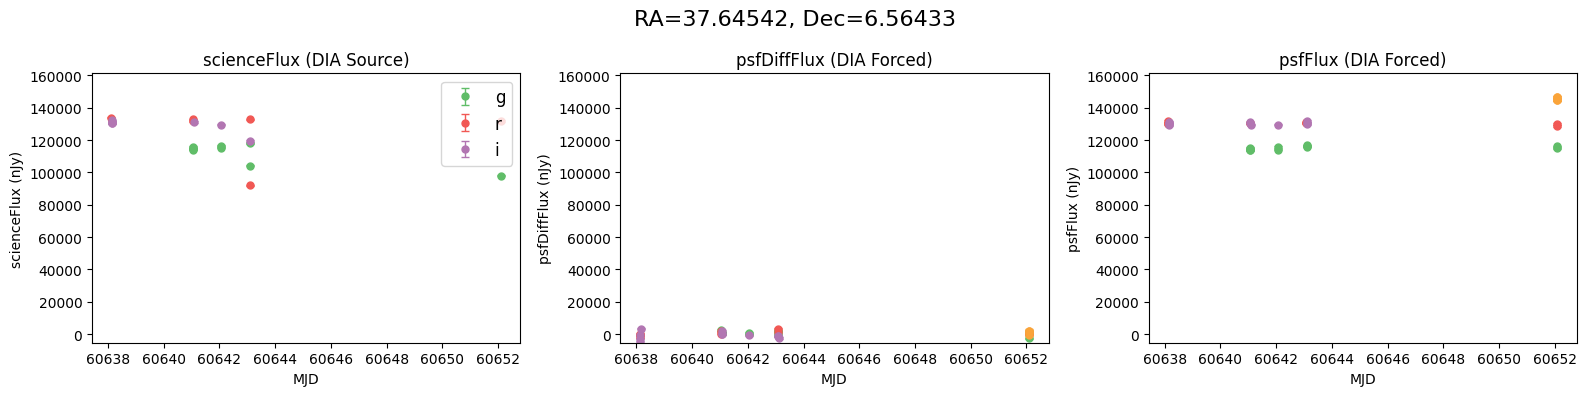

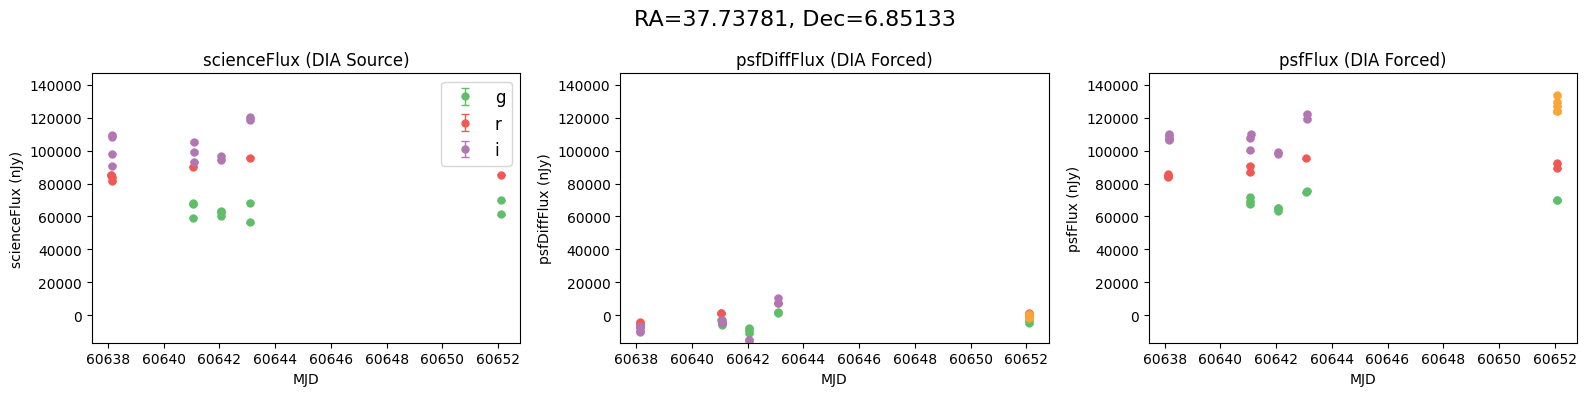

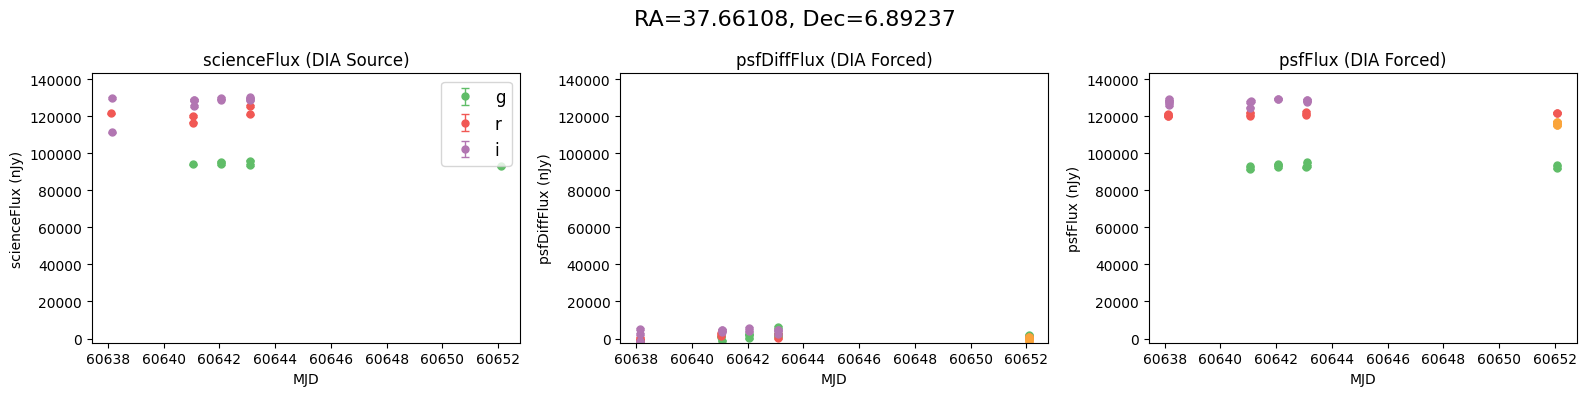

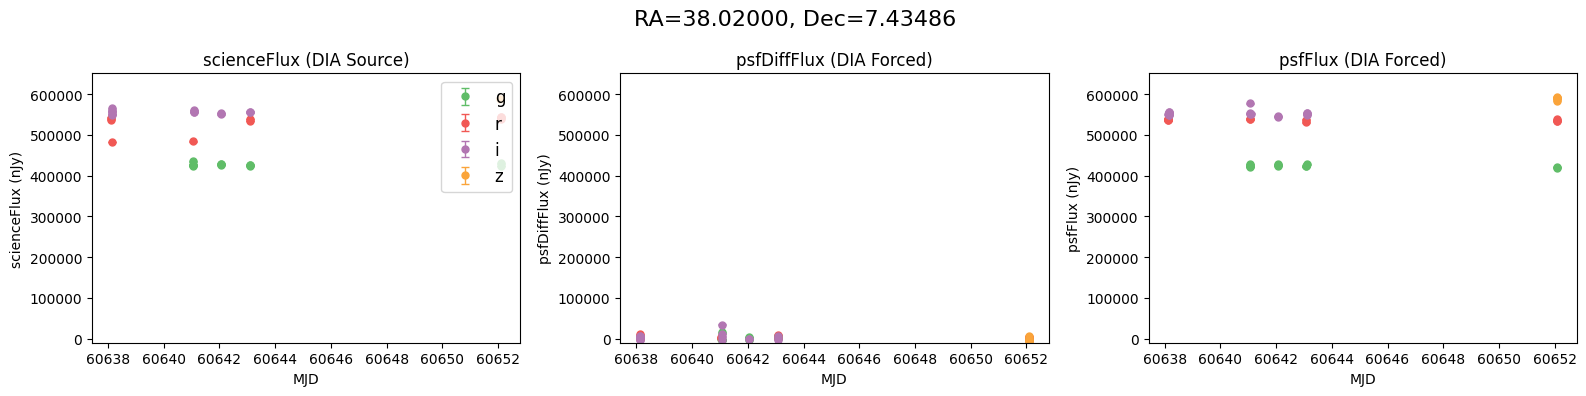

In [25]:
def plot_flux_scale(ax, lc, flux_col, flux_err_col, x_name, x_label, show_legend=False):
    flux_vals = []
    for band, color in COLORS.items():
        band_lc = lc.query(f"band == '{band}'")
        if band_lc.empty:
            continue
        ax.errorbar(
            band_lc[x_name],
            band_lc[flux_col],
            band_lc[flux_err_col],
            fmt="o",
            label=band,
            color=color,
            alpha=1,
            markersize=5,
            capsize=3,
            elinewidth=1,
        )
        flux_vals.extend(band_lc[flux_col].dropna().values)
    ax.set_xlabel(x_label)
    ax.set_ylabel(f"{flux_col} (nJy)")
    if show_legend:
        ax.legend(loc="upper right", fontsize=12)
    return flux_vals

def scale_flux_y_axis(ax, all_flux):
    if all_flux[0]:
        ymin, ymax = np.nanmin(all_flux[0]), np.nanmax(all_flux[0])
        for i in range(3):
            ax[0, i].set_ylim(ymin - 0.1 * abs(ymin), ymax + 0.1 * abs(ymax))

def plot_flux_lightcurves(ax, row):
    datasets = [
        ("scienceFlux", "DIA Source", row.diaSource_COM),
        ("psfDiffFlux", "DIA Forced", row.diaObjectForcedSource_COM),
        ("psfFlux", "DIA Forced", row.diaObjectForcedSource_COM),
    ]
    all_flux = [[]]
    for i, (flux_col, label, lc) in enumerate(datasets):
        flux_err_col = f"{flux_col}Err"
        ax[0, i].set_title(f"{flux_col} ({label})")

        all_flux[0].extend(
            plot_flux_scale(ax[0, i], lc, flux_col, flux_err_col, "midpointMjdTai", "MJD", show_legend=(i == 0))
        )
    return all_flux

for i in good_indices:
    row = ndf.loc[i]
    fig, ax = plt.subplots(1, 3, figsize=(16, 4))
    fig.suptitle(f"RA={row.ra_COM:.5f}, Dec={row.dec_COM:.5f}", fontsize=16)
    all_flux = plot_flux_lightcurves(np.expand_dims(ax, 0), row)
    scale_flux_y_axis(np.expand_dims(ax, 0), all_flux)
    plt.tight_layout()
    plt.show()


In [ ]:
# Flux error bars--there, just small

row = ndf.loc[good_indices[0]]
row.diaObjectForcedSource_COM[["psfFlux", "psfFluxErr"]].describe()

,psfFlux,psfFluxErr
count,36.000000,36.000000
mean,127880.529901,461.652596
std,10022.745270,140.459293
min,113652.694560,333.901438
25%,116149.343488,374.781211
50%,130029.282776,412.630799
75%,130961.238025,475.781990
max,146665.937686,854.261381


## Plot structure function

Referencing: https://github.com/rubin-dp0/delegate-contributions-dp02/blob/main/variable_stars/var_stars_sf.ipynb

In [34]:
from numba import njit

@njit
def calcSF(taumin, taumax, tclip, fclip, nstep):
    dtau = (np.log10(taumax) - np.log10(taumin)) / nstep
    tau1 = np.zeros(nstep)
    tau2 = np.zeros(nstep)
    N = np.zeros(nstep)
    SF = np.zeros(nstep)

    for k in range(nstep):
        tau1[k] = 10**(np.log10(taumin) + k*dtau)
        tau2[k] = 10**(np.log10(tau1[k]) + dtau)
        for i in range(tclip.size):
            dist = tclip[i:] - tclip[i]
            sel = (dist >= tau1[k]) & (dist < tau2[k])
            if np.any(sel):
                delta = fclip[i:][sel] - fclip[i]
                SF[k] += np.sum(delta**2)
                N[k] += sel.sum()
        SF[k] = np.sqrt(SF[k] / N[k]) if N[k] > 0 else np.nan

    return tau1, tau2, SF, N


In [48]:
import matplotlib.pyplot as plt
import pandas as pd

def SF_analysis(df, nstep=50, Nmin=2):
    objects = df['Object_ID'].unique()

    for obj in objects:
        obj_data_all = df[df['Object_ID'] == obj]

        fig_sf, ax_sf = plt.subplots(figsize=(7, 3))
        ax_sf.set_title(f"Structure Function: {obj}")

        for filt in sorted(df['Filter'].unique()):
            filt_data = obj_data_all[obj_data_all['Filter'] == filt].drop_duplicates(subset='Epoch')
            if filt_data.empty:
                continue

            filt_data = filt_data.sort_values(by='Epoch')
            mag = filt_data['Mag']

            # Iterative 5σ clipping
            count_old = len(mag) + 1
            count = len(mag)
            excluded = [[], []]

            while count_old > count:
                mag_mean = mag.mean()
                mag_std = mag.std(ddof=1)
                outliers = np.abs(mag - mag_mean) >= 5 * mag_std
                excluded[0] += filt_data['Epoch'][outliers].to_list()
                excluded[1] += mag[outliers].to_list()
                filt_data = filt_data[~outliers]
                mag = filt_data['Mag']
                count_old = count
                count = len(mag)

            if filt_data.empty:
                continue

            # Convert mag → normalized flux
            flux = 10**(-0.4 * (mag - np.median(mag)))
            time = filt_data['Epoch'].to_numpy()

            # SF time limits
            dtmin = np.min(np.diff(time))
            dtmax = time[-1] - time[0]
            taumin = 2 * dtmin
            taumax = 0.5 * dtmax

            tau1, tau2, SF, N = calcSF(taumin, taumax, time, flux.to_numpy(), nstep)

            ax_sf.loglog(tau1[N > Nmin], SF[N > Nmin], label=filt, marker="o", linestyle="")

        ax_sf.set_xlabel("Time lag (days)")
        ax_sf.set_ylabel("Structure Function")
        ax_sf.grid(True)
        ax_sf.legend()
        plt.show()


In [36]:
def make_long_df(catalog):
    rows = []
    for _, row in catalog.iterrows():
        obj_id = row.diaObjectId_COM
        for table in ['diaSource_COM', 'diaObjectForcedSource_COM']:
            lc = row[table]
            if lc.empty:
                continue
            for _, lc_row in lc.iterrows():
                if lc_row['psfFlux'] > 0 and not lc_row['psfFlux_flag']:
                    flux = lc_row['psfFlux']
                    flux_err = lc_row['psfFluxErr']
                    mag = -2.5 * np.log10(flux / 3631e9)  # Convert nJy to AB mag
                    rows.append({
                        'Object_ID': obj_id,
                        'Filter': lc_row['band'],
                        'Epoch': lc_row['midpointMjdTai'],
                        'psfFlux': flux,
                        'psfFluxErr': flux_err,
                        'Mag': mag,
                    })
    return pd.DataFrame(rows)

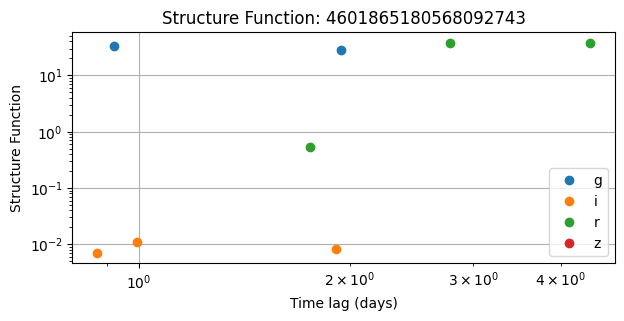

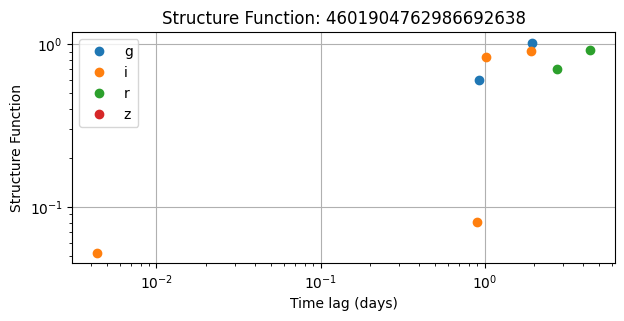

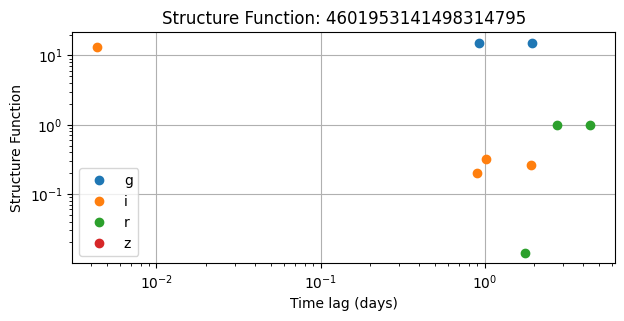

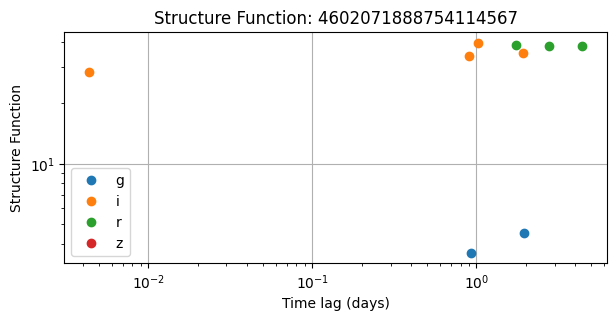

In [66]:
good_df = ndf.loc[good_indices]
lc_long_df = make_long_df(good_df)
SF_analysis(lc_long_df)

### All on the same plot

In [83]:
def SF_compare_plot(df, nstep=50, Nmin=2, legend=True):
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.set_title("Structure Functions (All Objects)")
    
    for obj in df['Object_ID'].unique():
        obj_data_all = df[df['Object_ID'] == obj]

        for filt in sorted(df['Filter'].unique()):
            filt_data = obj_data_all[obj_data_all['Filter'] == filt].drop_duplicates(subset='Epoch')
            if filt_data.empty:
                continue

            filt_data = filt_data.sort_values(by='Epoch')
            mag = filt_data['Mag']
            count_old = len(mag) + 1
            count = len(mag)
            while count_old > count:
                mag_mean = mag.mean()
                mag_std = mag.std(ddof=1)
                filt_data = filt_data[np.abs(mag - mag_mean) < 5 * mag_std]
                mag = filt_data['Mag']
                count_old = count
                count = len(mag)

            if filt_data.empty:
                continue

            flux = 10**(-0.4 * (mag - np.median(mag)))
            time = filt_data['Epoch'].to_numpy()
            dtmin = np.min(np.diff(time))
            dtmax = time[-1] - time[0]
            taumin = 2 * dtmin
            taumax = 0.5 * dtmax

            tau1, tau2, SF, N = calcSF(taumin, taumax, time, flux.to_numpy(), nstep)
            
            label = f"{obj} ({filt})"
            ax.loglog(tau1[N > Nmin], SF[N > Nmin], label=label, marker="o", linestyle="")

    ax.set_xlabel("Time lag (days)")
    ax.set_ylabel("Structure Function")
    ax.grid(True)
    if legend:
        ax.legend()
    plt.show()


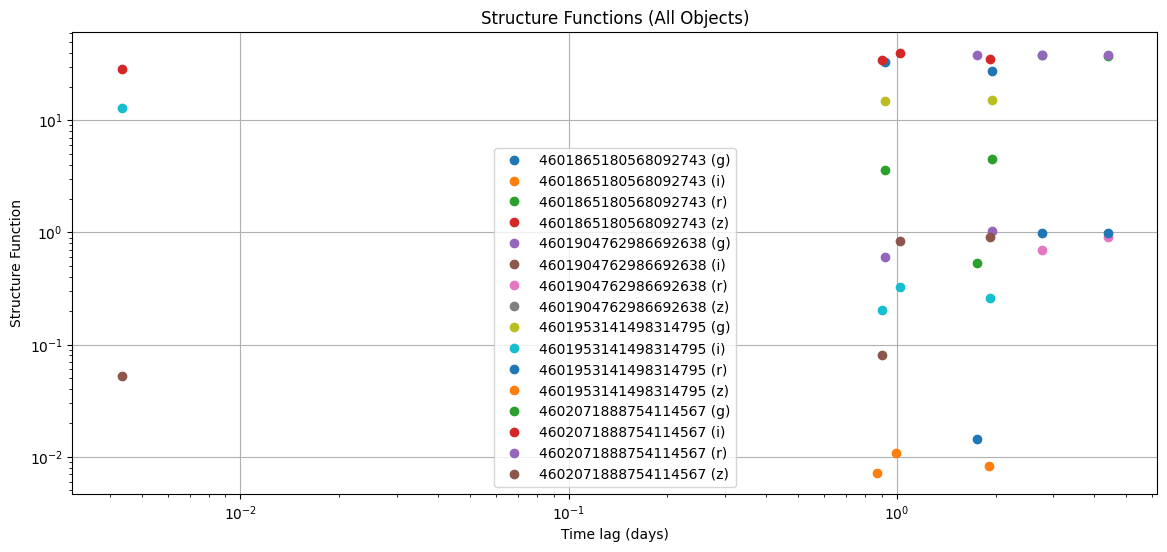

In [84]:
SF_compare_plot(lc_long_df)

In [69]:
good_indices_cut_at_10 = []

for i in ndf.index:
    if ndf.loc[i, "nDiaSources_COM"] > 10:
        print(f"Row {i} has {ndf.loc[i, 'nDiaSources_COM']} sources")
        good_indices_cut_at_10.append(i)

print(len(good_indices_cut_at_10))

Row 9612527476665096 has 22 sources
Row 9625426086025873 has 14 sources
Row 9629578309631688 has 13 sources
Row 9629995726864378 has 15 sources
Row 9634023935027569 has 28 sources
Row 9634690525906647 has 21 sources
Row 9638975471527747 has 12 sources
Row 9652264969173906 has 13 sources
Row 9652568124729885 has 12 sources
Row 9715348208376727 has 20 sources
Row 9726271155669546 has 14 sources
Row 9727321198035981 has 16 sources
Row 9734294853997666 has 18 sources
Row 9785092585129552 has 34 sources
14


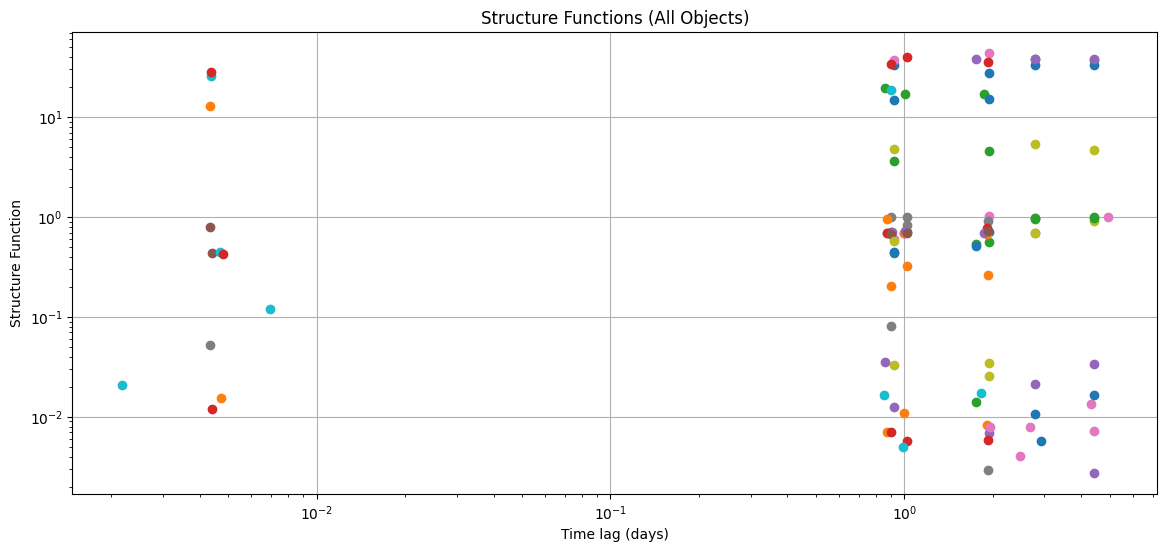

In [78]:
good_df_cut_at_10 = ndf.loc[good_indices_cut_at_10]
lc_long_df_cut_at_10 = make_long_df(good_df_cut_at_10)
SF_compare_plot(lc_long_df_cut_at_10, legend=False)